# <center> CFRM521 Machine Learning in Finance
## <center> Lecture 3
### <center> Yoshihiro Shirai

# Training Models and Regression, Part 2

- These lecture notes are partially based on "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition, by Aurelien Geron (O'Reilly), 2022."

- Chapter 4 and 1: Bias/variance tradeoff, learning curves, regularized linear models (ridge, lasso, and elastic net), logistic regression, problems with ML models.

# 0. Overview of the lecture

- In this lecture, we continue discussing how to train models.

- We revisit the bias/variance tradeoff which is one of the major principles of machine learning. We learn how to use learning curves to figure out if a model is underfitting or overfitting, and then selecting the best model using a validation set or cross-validation.

- Then we consider strategies to regularize a training algorithm in order to reduce overfitting.

- Regularization is controlled by a hyperparameter, and again the best model is selected using a validation set or cross-validation.

- Finally, we consider training logistic regression models. This is one of the simplest models for classifcation problems. It is used for binary classification, and is extended to multiclass classification using softmax.

# 1. Model complexity, bias and variance
- Here, we discuss the general relationship that increasing model complexity tends to lead to overfitting, decreasing bias, and increasing variance, while lowering model complexity does the opposite.

## 1.1 Bias/variance tradeoff

- The prediction error of a model can be decomposed into three parts: $$\text{Prediction error} = \text{Bias}^2+\text{Variance}+ \text{Irreducible error}$$

    - ***Prediction error***: the error in predicting the test set after the model has been trained

    - ***Irreducible error***: the error due to the noisiness of the data itself (e.g. error in measurements, random deviations due to factors that are not or cannot be accounted for). This error is inherent to the problem/task, it cannot be improved by fitting a better model

    - ***Bias***: the error due to wrong assumptions in the model (e.g. assuming a linear model when the data is generated by a nonlinear system)

    - ***Variance***: the error due to excessive sensitivity of the model to variations in the training data. An "overly complex" model tends to capture noise in the training set which will not generalize (outside the training set)

- Models with high bias are said to ***underfit*** the training set, while those with high variance ***overfit*** the training set

- Increasing complexity decreases bias but increases variance. This is called the bias/variance tradeoff

- How can we detect if a model is underfitting or overfitting?

- One way is to use a ***validation set***. Divide your training data into a training set and a validation set. Train using the training set and find the in-sample and out-of-sample performance of the model. If a model performs well on the training set (in-sample) and poor on the validation set (out-of-sample), then it is overfitting. If it performs poor on both training and validation sets, then it is underfitting.

- Alternatively, we may use learning curves

## 1.2 Performance Measures

- First, to determine performance, it is necessary to choose a performance measure.

- For regression problems, as opposed to classfication problems, a common performance measure is the root mean square error (RMSE).

- For any data set $\{(\mathbf{x}_n,\mathbf{y}_n)\}_{n=1}^N$ (this could be the training, validation, or test set), the RMSE is given by $$\text{RMSE} = \sqrt{\frac{1}{N}\sum_{n=1^N}^N(y_n-h(\mathbf{x}_n))^2}$$, where $h(\mathbf{x}_n)$ is the prediction of the target variable for the feature $\mathbf{x}_n$, and in the case of linear regression $$h(\mathbf{x}_n)=\mathbf{x}_n^T\hat{\theta}$$.

- An alternative performance measure is the mean absolute error (MAE) given by $$\text{MAE}=\frac{1}{N}\sum_{n=1}^N\left\lvert y_n-h(\mathbf{x}_n)\right\rvert$$.
  
- The MAE is less sensitive to outliers than than the RMSE, due to using an absolute value instead of a square.

- We will use the RMSE.

## 1.3. Learning curves

- Let us illustrate the bias/variance tradeoff using polynomial regression

- The data is generated by a quadratic model: $y_n=2+x_n+0.5x^2_n+\varepsilon_n$

In [63]:
import numpy as np
np.random.seed(42)
N = 100
X = 6 * np.random.rand(N, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(N, 1)

- Again, in this example, let us treat this data as if it is the training set created from the full data.

- This is a simulated example, where we want to fit some models, determine whether they are underfitting or overfitting or neither, and then select the best model.

In [64]:
import matplotlib as mlp
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

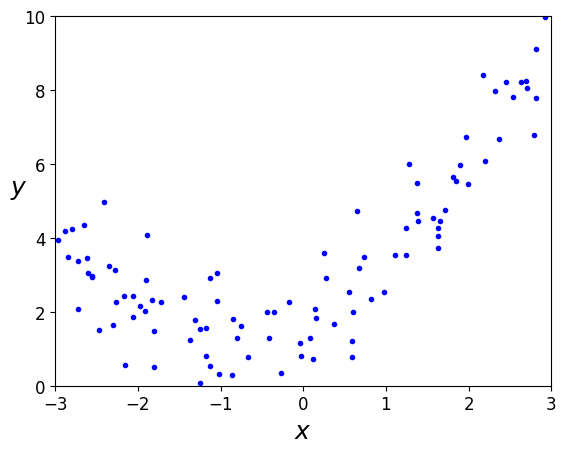

In [65]:
plt.plot(X, y, "b.")
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

- We can fit this data using a polynomial regression model $$y_n=\theta_0+\theta_1x_n+\theta_2 x_n^2+\varepsilon_n$$

- Note that this is a linear regression model with two features, $x_{n,1}=x_n$ and $x_{n,2}=x_n^2$.

- We start by adding a new feature as the square of the existing feature. Scikit-Learn's `PolynomialFeatures` class is handy for this task

- `PolynomialFeatures` adds all combinations of features (interactions) up to the given degree. If there were two features $a$ and $b$, `PolynomialFeatures` with `degree=3` would not only add the features $a^2$, $a^3$, $b^2$, and $b^3$, but also the combinations  $ab$, $a^2b$ and $ab^2$.

In [66]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [67]:
X[0]

array([-0.75275929])

In [68]:
X_poly[0]

array([-0.75275929,  0.56664654])

- We then fit a linear regression model using `X_poly` as the features

In [69]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

- The fitted model is $$y_n= 1.78134581+0.93366893 x_n+0.56456263x_n^2$$


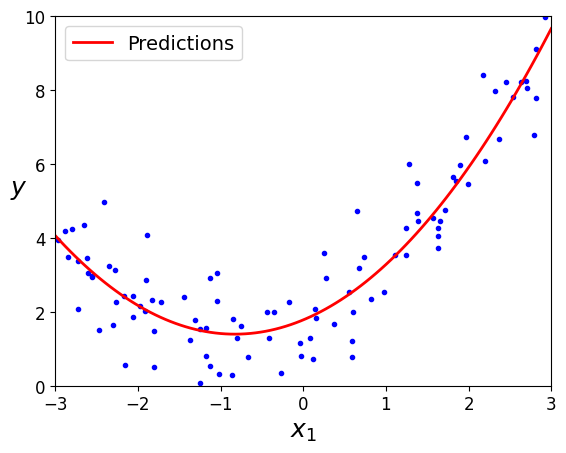

In [70]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

- In this example, we know that the data generating process is a quadratic function. So, a quadratic polynomial is the best model for the data

- However, without this knowledge, we may have been tempted to try higher degree polynomials

In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def polyReg_plot(X, y, X_new, params=(2,"r-",2,"Predictions")):
    # params = (degree, style, width, label)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    for degree, style, width, label in params:
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        polynomial_regression = Pipeline([
                ("poly_features", poly_features),
                ("std_scaler", std_scaler),
                ("lin_reg", lin_reg),
            ])
        polynomial_regression.fit(X, y)
        y_new = polynomial_regression.predict(X_new)
        plt.plot(X_new, y_new, style, linewidth=width, label=label)
    plt.plot(X, y, "k.", linewidth=3)
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$y$", rotation=0, fontsize=18)
    plt.axis([-3, 3, 0, 10])
    plt.show()

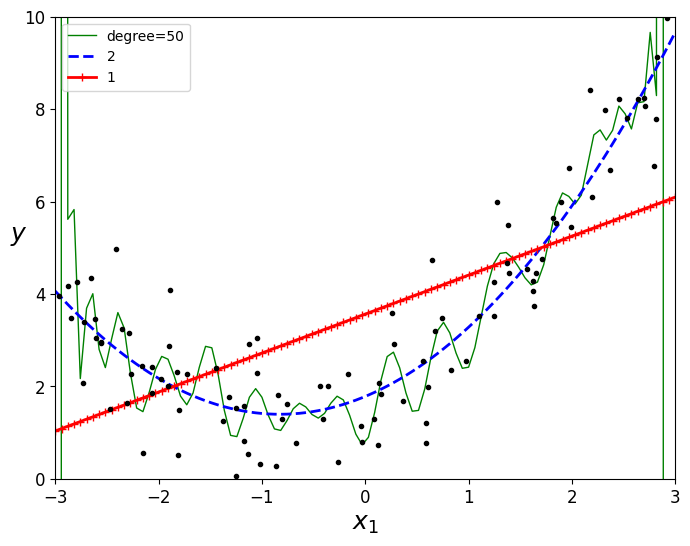

In [72]:
plt.figure(figsize=(8,6))
params = ((50, "g-", 1, "degree=50"), (2, "b--", 2, "2"), (1, "r-+", 2, "1"))
polyReg_plot(X, y, X_new, params=params)

- Clearly, the degree 50 polynomial is overfitting, while the degree 1 is underfitting

- Learning curves are plots of a model's performance on training and validation set as a function of the size of the training set

- Let us first define a function to plot learning curves, using the root mean square error (RMSE) as the performance measure

In [73]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="valid")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)              

- Next, we obtain the learning curve of the linear regression for the quadratic data

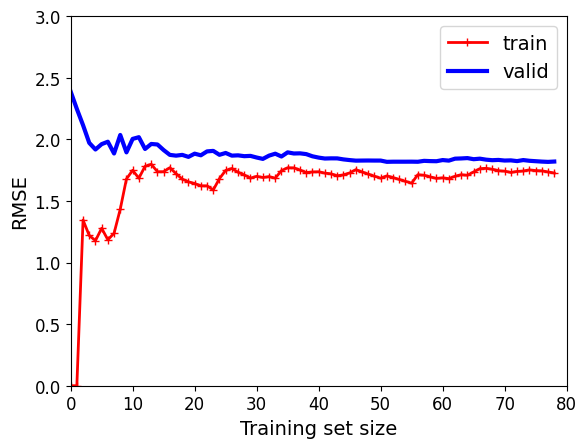

In [74]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                     
plt.show()

- As you can see, the performance on the training set (the in-sample performance) becomes worse as the training set gets larger

- The performance on the validation set (the out-of-sample performance) improves with the size of the training set

- Both in-sample and out-of-sample performance "**reach a plateau**" with almost no gap between them. The error size is large (the performance is not good). These are the typical characteristic of the learning curves when the model is **underfitting** the training set

- Next, let us take a look at the learning curves of the degree 20 polynomial

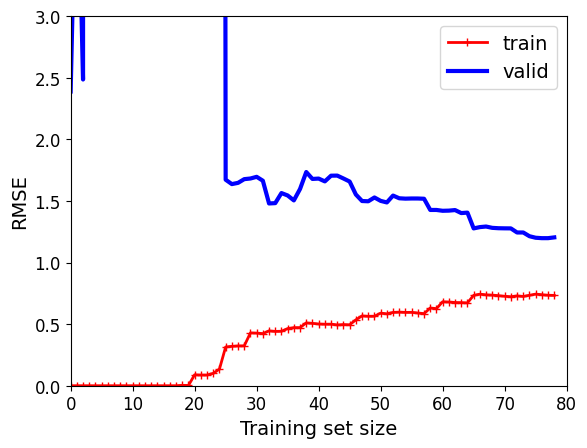

In [75]:
polynomial_regression_deg20 = Pipeline([
        ("poly_features", PolynomialFeatures(degree=20, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression_deg20, X, y)
plt.axis([0, 80, 0, 3]) 
plt.show()   

- The learning curves looks similar to the linear regression, with two important difference

- The in-sample error is lower

- There is a large gap between in-sample and out-of-sample error

- These are the typical characteristic of the learning curves when the model is overfitting the training set

- Finally, let us obtain the learning curve of the quadratic regression model

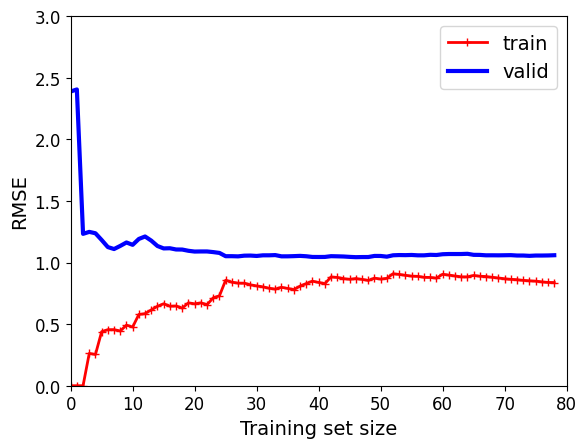

In [76]:
polynomial_regression_deg2 = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression_deg2, X, y)
plt.axis([0, 80, 0, 3]) 
plt.show()

- The in-sample and out-of-sample errors are closer than those for the degree 20 polynomial regression model. Also, the performance is much better than the (degree 1) linear regression model.

- The degree 2 polynomial regression model is the best model here based on having the lowest RMSE on the full validation set, while the degree 20 model is overfitting and the degree 1 model is underfitting.

- Increasing a model’s complexity (in this example, the degree of the polynomials) will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is why it is called a tradeoff.

## 1.4 Model selection

- How do we do model selection?

- We should evaluate how well each model does based on a performance measure on the out-of-sample data. This gives the generalization error of each model, and we should select the model where this is smallest. Could the test set be used for this?

- No. The test set can only be used to obtain the generalization error of the final model. It cannot be used to select models (or hyperparameters; the degree of the polynomial regression model, 1, 2, or 20, can be thought of as a hyperparameter) as that would lead to overfitting.

- Instead, one way to do this is to use the **validation set**: train the model on the training set, then evaluate the performance measure, which is the RMSE in this example, on the validation set.

- We have already done this above. This is equivelent to reading off the RMSE on the right-most point of the learning curve for the validation set.

- Alternatively, we can use **cross-validation**.

## 1.5 K-fold cross-validation

- The problem with using a validation set is that it reduces the sample size avaliable for training and validation, and is subject to randomness. For example, 20% of the initial training set may be used to create the validation set.

- To address these problems, instead of one validation set based on 20% of the sample, we can repeat this 5 times for a different 20% each time. This is 5-fold cross-validation.

- More generally, the idea is to split the training set into $K$ smaller subsets called folds

- We then train the model $K$ times

- At iteration $i$, we train the model using all folds except the $i$-th fold. Then, we evaluate the trained model using the $i$-th fold

- After $K$ iterations, we obtain $K$  out-of-sample performance measures for the model. This can then be averaged to get the estimate of the out-of-sample performance measure, and then the best model is chosen.

- Cross-validation is generally better than using a validation set. But it comes at the cost of higher computational time. We can use Scikit-Learn's `cross_val_score()` function for $K$-fold cross-validation

- For cross-validation, it is important that the training set is shuffled, since the splits are done deterministically.

- Here, the data is already shuffled. If the $x$ features were ordered, part of the range of $x$ would be missing in each fold, which will cause the model to produce bad predictions and would not fairly represent the actual performance of the model.

- Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row.

- Note that time series data should not be shuffled, and we will discuss how to do cross-validation for this in later lectures.

- Just to show how to shuffle a training set, let us do so on our training set. Note that this step is not necessary here, but, reshuffling also doesn't hurt.

In [77]:
np.random.seed(42) # to make this notebook's output stable across runs

shuffle_index = np.random.permutation(100)
X, y = X[shuffle_index], y[shuffle_index]

- Finally, let's obtain the 5-fold cross-validation of the RMSE for the linear regression model.

In [78]:
from sklearn.model_selection import cross_val_score

cv_rmse = -cross_val_score(lin_reg, X, y, cv=5, scoring="neg_root_mean_squared_error")
print(cv_rmse)

[1.59193168 2.04057642 1.92174125 1.52481672 1.76571658]


- We should take an average over these 5 folds to estiamte the out-of-sample RMSE for this model.

In [79]:
np.mean(cv_rmse)

1.7689565316190183

- Next, we obtain the out-of-sample RMSE for degree 20 polynomial regression model.

In [80]:
np.mean(-cross_val_score(polynomial_regression_deg20, X, y, cv=5, scoring="neg_root_mean_squared_error"))

1.987207185261439

- Finally, we obtain the out-of-sample RMSE for degree 2 polynomial regression model.

In [81]:
np.mean(-cross_val_score(polynomial_regression_deg2, X, y, cv=5, scoring="neg_root_mean_squared_error"))

0.9044488359669369

- As expected, the degree 2 polynomial regression is the model that should be selected. It has the best out-of-sample performance measure (lowest RMSE).

- In fact, instead of writing our own function to plot the learning curve on a validation set, as done above, the learning_curve() function in sklearn.model_selection creates a learning curve using cross-validation.

- By default, it uses 5-fold CV, so creates 5 learning curves plotting RMSE. We take their average to form a single learning curve.

- We demonstrate how this is done for the degree 2 polynomial regression model.

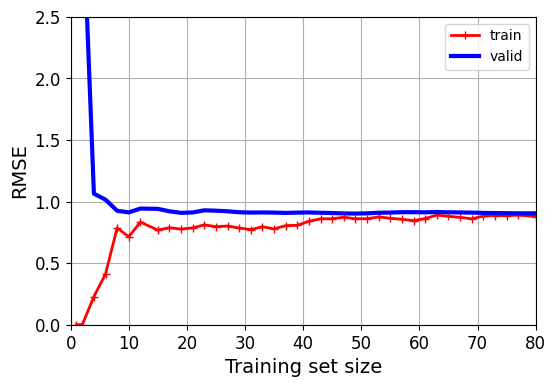

In [82]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression_deg2, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
plt.show()

- As expected, the RMSE on the right-most point of the learning curve by CV is the same as the out-of-sample RMSE by CV calculated above (0.9).

- Using `learning_curve` to redo all the learning curves above does not change any of the conclusions. But it does reduce the random noise due to the random splitting into a traning and validation set, which removes the gap seen in the learning curve for the degree 2 polynomial regression model that we previously saw.

# 2. Regularized linear models

- To obtain a better bias/variance tradeoff, we must **regularize** a model one way or another. That is, we should restrict its parameter space by adding constraints to the parameters

- For a linear regression model, regularization is achieved by constraining the weights of the model (or, equivalently, adding penalty terms to the cost function)

- We consider three different regularized linear models, namely, "**Ridge Regression**," "**Lasso Regression**," and "**Elastic Net**"

## 2.1. Ridge regression

- Multicollinearity (i.e. highly linearly dependent features) presents a numerical challenge (why?)

- To address it, in ridge regression, a quadratic penalty term is added to the cost function, $$J(\theta)=\text{MSE}(\theta)+\frac{\alpha}{N}\sum_{i=1}^M\theta_i^2$$

- Note that the bias term $θ_0$ is not included in the penalty term

- The penalty term forces the feature weights $\theta_1,...\theta_M$ to be small

- The hyperparameter $\alpha$ controls the level of bias/variance tradeoff. If $\alpha=0$, ridge regression is the (non-regularized) linear regression. If $\alpha$ is very large, then ridge regression only fits a bias term (which will be equal to the average target values)

- It is important to scale the features (e.g. divide by their sample standard deviations) before performing ridge regression. Otherwise, the penalty term will be dominated by the larger feature weights. In general, one must scale the features before using most regularized models

- The minimizer of $J(\theta)$ is: $\hat{\theta}:=(\mathbf{X}^T\mathbf{X}+\alpha\mathbf{A})^{-1}\mathbf{X}^T\mathbf{y}$, where $\mathbf{A}$ is an $(M+1)\times (M+1)$ diagonal matrix with diagonal $(0,1,...,1)$

- Alternatively, we may use GD. The GD iteration for ridge regression is $$\theta^{(k+1)}=\theta^{(k)}-\eta_k \left[\frac{2}{N}\mathbf{X}^T(\mathbf{X}\theta^{(k)}-\mathbf{y})+\frac{2\alpha}{N}\left(0,\theta_1^{(k)},...,\theta_M^{(k)}\right)^T \right]$$

- Let us fit a ridge regression. First, we create a sample data set

In [83]:
np.random.seed(42)
N = 20
X = 3 * np.random.rand(N, 1)
y = 1 + 0.5 * X + np.random.randn(N, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

- We may use Scikit-Learn's `Ridge` class to fit a ridge regression

- We may use the closed form formula

In [84]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=0.1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

- Or SGD (SAG stands for stochastic average GD, which is a variation of SGD)

In [85]:
ridge_reg = Ridge(alpha=0.1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55326019]])

- We may also use the `SGDRegressor` class, by passing the argument `penalty="l2"` (this is a reference to the fact that the penalty term of ridge regression is an $\ell_2$ norm)

In [86]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1/N, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.55302613])

- Next, we plot some ridge regression with different hyperparamter $\alpha$

In [87]:
def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = (model_class(alpha, **model_kargs)
                 if alpha > 0 else LinearRegression())
        if polynomial:
            model = Pipeline([
                    ("poly_features",
                     PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw,
                 label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

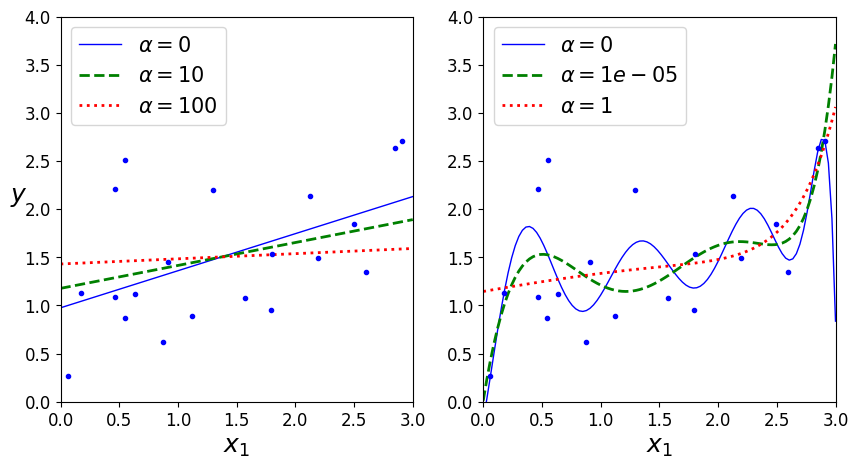

In [88]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.show()

- How is the optimal hyperparameter value $\alpha$ chosen?

- Choose hyperparameters to minimize the performance measure (for example, RMSE here) on the validation set or the cross-validation performance. This is known as **hyperparameter tuning**.

- Hyperparameter tuning using cross-validation is done in Homework 1 using the functions `GridSearchCV` or `RandomizedSearchCV`, which computes the performance measure for various values of the hyperparameter and chooses the value with the best performance.

# 2.2. Lasso regression

- In **Least Absolute Shrinkage and Selection Operator (lasso) Regression**, the regularization term is the $\ell_1$ norm of the feature weights. Thus, the cost function is $$J(\theta)=\text{MSE}(\theta)+2\alpha\sum_{i=1}^M|\theta_i|$$

- The main feature of the lasso regression is that it tends to assign zero weight to the least important features, thus, automatically performing feature selection

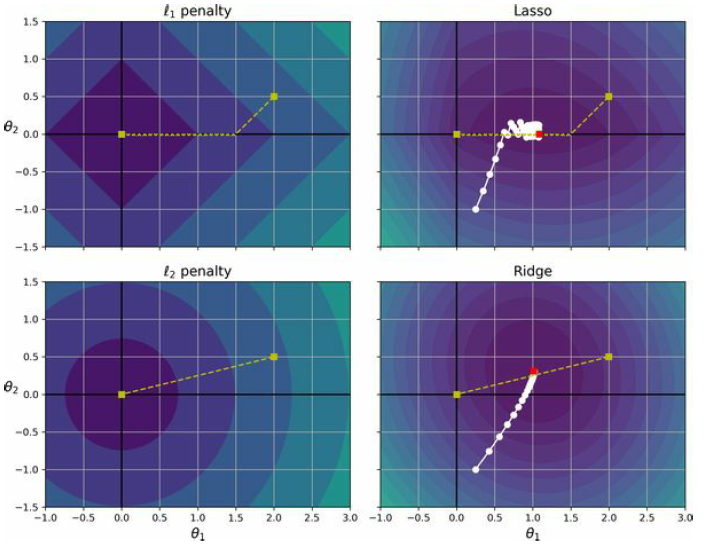

In [89]:
from IPython.display import Image
Image("Figs/Lasso.png", width=600)

- To fit lasso regression, we can either use Scikit-Learn's `Lasso` class or `SGDRegressor` class with the `penalty="l1"` argument

In [90]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

In [91]:
sgd_reg = SGDRegressor(penalty="l1", alpha=2*0.1, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.52125475])

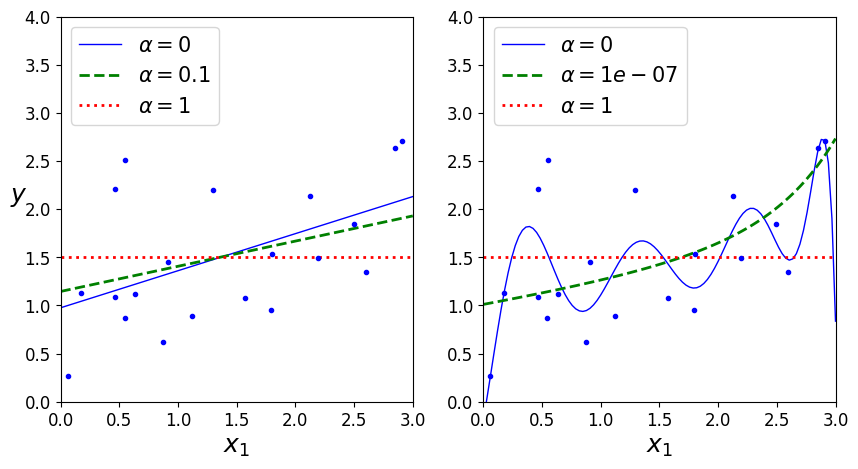

In [92]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)
plt.show()

## 2.3. Elastic Net

- Elastic Nets are a middle ground between ridge and lasso regression models

- The penalty term in elastic nets are a mixture of $\ell_1$ and $\ell_2$ norms. The cost function is $$J(\theta)=\text{MSE}(\theta)+r2\alpha\sum_{i=1}^M|\theta_i|+(1-r)\frac{\alpha}{N}\sum_{i=1}^M\theta_i^2$$

- There are two hyperparameters, $\alpha$ and $r$. If $r=0$, we get ridge regression, if $r=1$, we get lasso regression

- You can use Scikit-Learn's class `ElasticNet` to fit elastic net. The argument `l1_ratio` is the hyperparameter $r$

In [93]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

- So, what regularization should we use (if any)?

- No method is generally better than the other.

- Ridge and lasso generally perform similarly, though ridge generally has lower test MSE if all features contribute to the true model.

- Lasso is more interpretable and comes with feature selection.

- As a rule of thumb, use ridge regression. If you suspect that there are many "useless" features, use lasso regression or elastic net. Elastic net is preferred to lasso, since the latter does not behave well when there are more features than training examples

# 3. Logistic regression

- Logistic (or logit) regression is a simple machine learning model for classification problems (predicting classes).

- This method is for binary classification (i.e. two classes). We extend it to multiclass classification using softmax below.

- Suppose we have a random sample $\{(\mathbf{X}_n,Y_n)\}_{n=1}^N$, which takes the values $\{(\mathbf{x}_n,y_n)\}_{n=1}^N$

- The logistic regression model is $$\mathbb{E}[Y_n|\mathbf{X}_n]=H(\theta\cdot \mathbf{X}_n)$$

- Here, the response variables are binary labels (either 0 or 1) and $H(x)=\frac{1}{1+e^{-x}}$ is the logistic function.

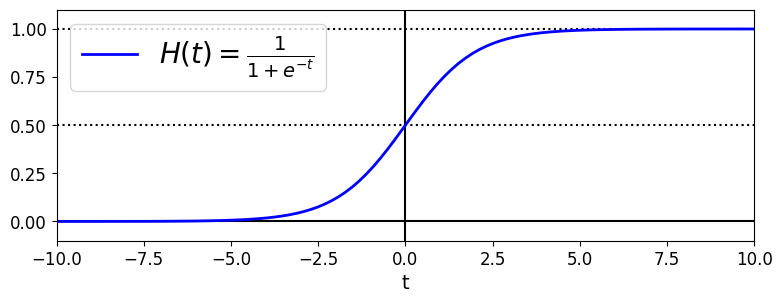

In [94]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$H(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

- The parameters $\theta$ are estimated by Maximum Likelihood Estimation (MLE)

- $Y_n|\mathbf{X}_n$ are i.i.d. Bernoulli random variables with parameter $p=\mathbb{P}(Y_n=1|\mathbf{X}_n)=H(\theta \cdot\mathbf{X}_n)$

- The likelihood function is then $$\begin{align*} L(\theta) & = \prod_{n=1}^N\mathbb{P}(Y_n=y_n|\mathbf{X}_n=\mathbf{x}_n)\\ & =\prod_{n=1}^N\left[\mathbb{P}(Y_n=1|\mathbf{X}_n=\mathbf{x}_n)\right]^{y_n}\left[\mathbb{P}(Y_n=0|\mathbf{X}_n=\mathbf{x}_n)\right]^{1-y_n}\\ & =\prod_{n=1}^N\left[H(\theta\cdot \mathbf{x}_n)\right]^{y_n}\left[1-H(\theta\cdot \mathbf{x}_n)\right]^{1-y_n}\end{align*} $$

- Maximizing this likelihood function is equivalent to minimizing the so-called log loss function $$\begin{align*}J(\theta)&=-\frac{1}{N}\log L(\theta)\\&=-\frac{1}{N}\sum_{n=1}^N\left[y_n(\log H(\theta\cdot \mathbf{x}_n)+(1-y_n)\log \left(1-H(\theta\cdot \mathbf{x}_n)\right)\right]\end{align*}$$

- To fit the model, we should solve the optimization problem $$\hat{\theta}= \text{arg}\min_{\theta}J(\theta)$$ 

- This optimization problem does not have a closed form solution.

- However, the log loss function is convex and the GD algorithm is guaranteed to converge to the global minimum.

- We can include a regularization term, similar to linear regression.

- We can implement batch GD, SGD or mini-batch GD, similar to linear regression.

- Let us use the iris dataset to show case logistic regression

- This famous dataset contains four dimensions (petal length, petal width, sepal length, and sepal width) of 150 iris flowers from 3 different species (iris-setosa, iris-versicolor, and iris-virginica)

In [95]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [96]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

- Let us train a binary classifier to detect iris-virginica

- At first, we only consider one feature, namely, the petal width

- We should create a test set. However, since we are using this as an example, we take all the data as our training set.

In [97]:
X = iris["data"][:, 3:]  # petal width, it is important for X to be 2 dimensional (i.e. a list of list instead of just a list)
y = (iris["target"] == 2).astype(int)  # 1 if Iris-Virginica, else 0

- We can use the `LogisticRegression` class to fit a regularized logistic regression.

- The hyper-parameter for regularization is `C` which is the inverse of $\alpha$ used in ridge, lasso, and elastic net regressions. The low values of `C` indicate more regularization. The regularization penalty can be $\ell_2$ or $\ell_1$ norm. Let us set $C=\infty (\alpha=0)$

In [98]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=np.inf, random_state=42,solver='lbfgs')
log_reg.fit(X, y)

LogisticRegression(C=inf, random_state=42)

- Let us see how the fitted logistic regression makes decisions. We find the probability of being iris-virginica for all petal widths between 0-3 cm

- Note that LogisticRegression outputs probabilities of being in each class. It has a ``.predict_proba()` method for this.

- Note that using `.predict()` will return whichever class is the most likely.

In [99]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1) #.reshape(-1, 1) reshapes to an array with column 1.
y_proba = log_reg.predict_proba(X_new)

- Let us also calculate the decision boundary, that is, at what petal width a flower is classified as iris-virginica

In [38]:
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]
decision_boundary

array([1.63363363])

We may illustrate our findings as the figure below.

C:\Users\yoshi\AppData\Local\Temp\ipykernel_21800\1561503473.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.arrow(float(decision_boundary), 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
C:\Users\yoshi\AppData\Local\Temp\ipykernel_21800\1561503473.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.arrow(float(decision_boundary), 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')


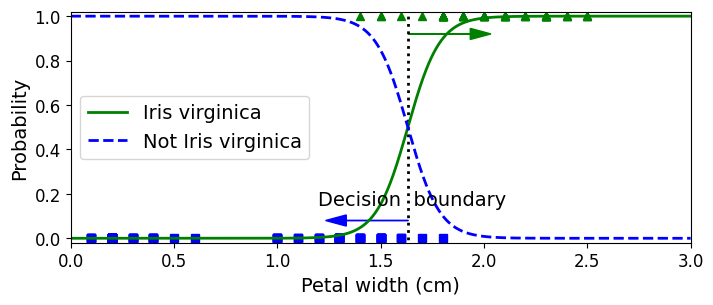

In [101]:
plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(float(decision_boundary), 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(float(decision_boundary), 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

- Next, let us use two features for the binary classification task. That is, both petal dimensions.

In [102]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(int)

- We fit the model as before.

In [103]:
log_reg = LogisticRegression(C=np.inf, random_state=42, solver='lbfgs')
log_reg.fit(X, y)

LogisticRegression(C=inf, random_state=42)

- Let us see how the probability of being iris-virginica changes with petal dimensions.

- We create a "meshgrid" of possible values of petal length and width. This will be used for plotting two dimensional contour plots.

In [104]:
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1),
                     np.linspace(0.8, 2.7, 200).reshape(-1, 1))

In [105]:
x0.shape

(200, 500)

In [106]:
x1.shape

(200, 500)

- Next, we calculate the probabilities of being iris-virginica for all petal dimensions on the meshgrid.

In [107]:
X_new = np.c_[x0.ravel(), x1.ravel()] #ravel is used to flatten the array, e.g. [[1,2],[1,2],[1,2]] -> [1,2,1,2,1,2]
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

- We can now plot the probability of being iris-virginica as a function of petal dimensions.

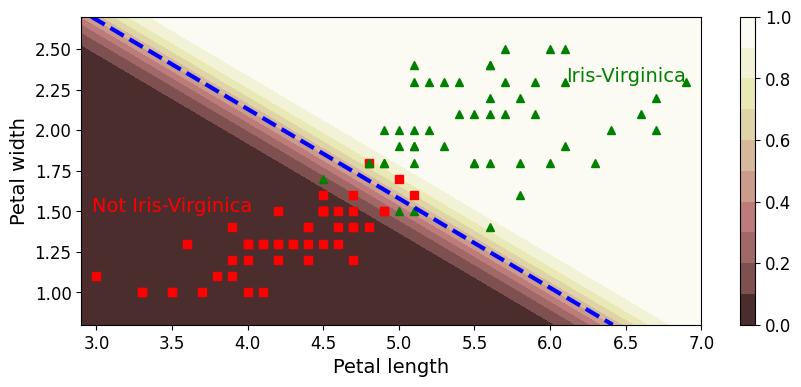

In [108]:
from matplotlib import cm
plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "rs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="r", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
cs = plt.contourf(x0, x1, zz, np.linspace(0,1,11), cmap=cm.pink)
cbar = plt.colorbar(cs)
plt.contour(x0, x1, zz, [0.5], colors=['b'],
           linewidths=[3], linestyles=["dashed"])
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

# 4. Softmax regression

- Let us consider a ternary (three-class) classification of the iris dataset.

- We may also consider a generalized version of logistic regression that directly supports multiclass classification. This generalization is called softmax (or multinomial logistic) regression.

- In logistic regression, we have two classes and the probability of being in class 2 (as opposed to class 1) given a set of features $\mathbf{x}$ is $$p_2(\mathbf{x})=\mathbb{P}(Y=2|\mathbf{X}=\mathbf{x})=H(\theta\cdot\mathbf{x})=\frac{e^{\theta\cdot\mathbf{x}}}{1+e^{\theta\cdot\mathbf{x}}}$$

- In softmax regression, we have $M$ classes and the probability of being in class $m$ given a set of features $\mathbf{x}$ is $\mathbf{x}$ is $$p_m(\mathbf{x})=\mathbb{P}(Y=m|\mathbf{X}=\mathbf{x})=\frac{e^{\theta_m\cdot\mathbf{x}}}{\sum_{k=1}^Me^{\theta_k\cdot\mathbf{x}}}$$

- Here, $\theta_1,...,\theta_M$ are $M$ vectors of feature weights (each corresponding to one class). They are unknown and need to be estimated using MLE.

- Assume that we are given a training set $\{(\textbf{x}_n,y_n)\}_{n=1}^N$

- $\mathbf{x}_n$ is the vector of features in the n-th observation and $y_n$ is the class of the n-th observation (a value in $\{1,...,M\}$)

- The likelihood of the n-th observation if the true values of the parameters are  $\theta_1,...,\theta_M$ is $$p_{y_n}(\mathbf{x}_n)=\frac{e^{\theta_{y_n}\cdot\mathbf{x}_n}}{\sum_{k=1}^Me^{\theta_{y_k}\cdot\mathbf{x}_k}}$$

- Let us define $y_{n,m}:=\mathbb{1}_{y_n=m}$, which is equal to 1 if $y_n=m$ and otherwise it is zero. In other words, $\{y_{n,1},...,y_{n,M}\}$ are the **one-hot encoding** (see Chapter 2 of the textbook) of $y_n$.

- Then, we have $$p_{y_n}(\mathbf{x}_n)=\prod_{m=1}^Mp_m(\mathbf{x}_n)^{y_{n,m}}$$

- The likelihood function is then 
$$\begin{align*}
L(\theta_1,...,\theta_M) 
& = \prod_{n=1}^N\mathbb{P}(Y_n=y_n|\mathbf{X}_n=\mathbf{x}_n)
  = \prod_{n=1}^N p_{y_n}(\mathbf{x}_n)
  = \prod_{n=1}^N \prod_{m=1}^Mp_m(\mathbf{x}_n)^{y_{n,m}}\\
& = \prod_{n=1}^N \prod_{m=1}^M 
      \left(\frac{e^{\theta_{n}\cdot\mathbf{x}_n}}{\sum_{k=1}^Me^{\theta_{k}\cdot\mathbf{x}_k}}\right)^{y_{n,m}}
\end{align*}$$ 

- Maximizing the likelihood function is equivalent to minimizing the so called **cross entropy function** (also called **cost function**)
$$\begin{align*}
J(\theta_1,...,\theta_M) 
& = -\frac{1}{N}\log(L(\theta_1,...,\theta_M))\\
& = -\frac{1}{N}\sum_{n=1}^N \sum_{m=1}^M 
      y_{n,m}\log\left(\frac{e^{\theta_{n}\cdot\mathbf{x}_n}}{\sum_{k=1}^Me^{\theta_{k}\cdot\mathbf{x}_k}}\right)
\end{align*}$$

- The minimization of the cost function can be performed via, say, any variation GD

- Once the estimates $\hat{\theta}_1,...,\hat{\theta}_M$ are obtained, the probability of being in class $m$ is in turn given by
$$\begin{align*}
\hat{p}_m(\mathbf{x})=\frac{e^{\hat{\theta}_m\cdot\mathbf{x}}}{\sum_{k=1}^Me^{\hat{\theta}_k\cdot\mathbf{x}}}
\end{align*}$$

- The predicted class is the class with the largest estimated probability.

- Let’s use Softmax Regression to classify the iris flowers into all three classes (0 = setosa, 1 = versicolor, 2 = virginica).

- The `LogisticRegression` class implements softmax regression as well. To do this, use `multi_class="multinomial"` and specify a solver that supports softmax such as `lbfgs`. The optimization is regularized as in the case of logistic regression using the argument `C` (smaller values mean more regularization). If you pass labels with more than 2 classes, this is the default behavior.

In [47]:
from sklearn.linear_model import LogisticRegression
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(C=1, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=1, random_state=42)

In [48]:
from sklearn.linear_model import LogisticRegression
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs",
                                 C=1, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=1, multi_class='multinomial', random_state=42)

- The figure below illustrates the decision boundaries and the training set. The contour lines show the probabilities for the iris-versicolor class.

In [49]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

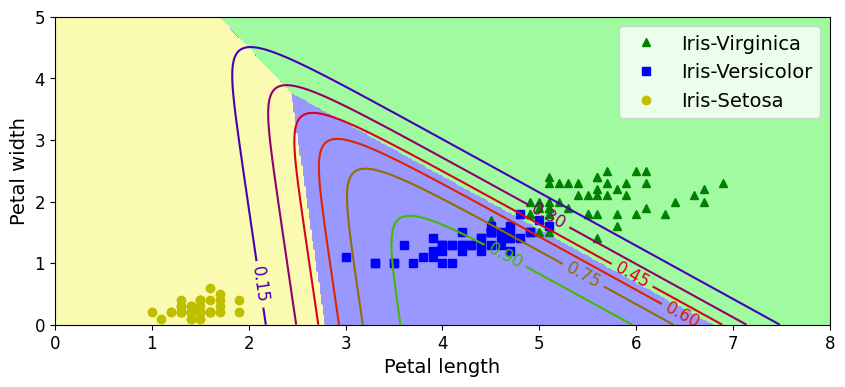

In [50]:
plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")
plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper right", fontsize=14)
plt.axis([0, 8, 0, 5])
plt.show()

# 5. Problems with ML models

- So far we have discussed issues with training ML models. This includes the problem of under- and overfitting the data, which can be addressed by selecting a flexible model and using regularization during training.

- However, problems relating to the training data may be difficult to fix even with good training.

- These problems can include: lack of data, poor quality data, and nonrepresentative data.

- Training a model on nonrepresentative data will likely result in biased outcomes. To generalize well, it is crucial that your training data be representative of the new cases you want to generalize to.

- In the following figure, a linear model has been fit to a non-representative sample of countries that does not include those with GDP per capita lower than \$23,500 or higher than \$62,500. This is shown by the blue line, which indicates that higher GDP per capita is strongly associated with higher life satisfaction.

- However, when adding back those countries that have been excluded (red squares), as shown by the black line, the result is less strong, with some very rich countries not being as happy as moderately rich countries.

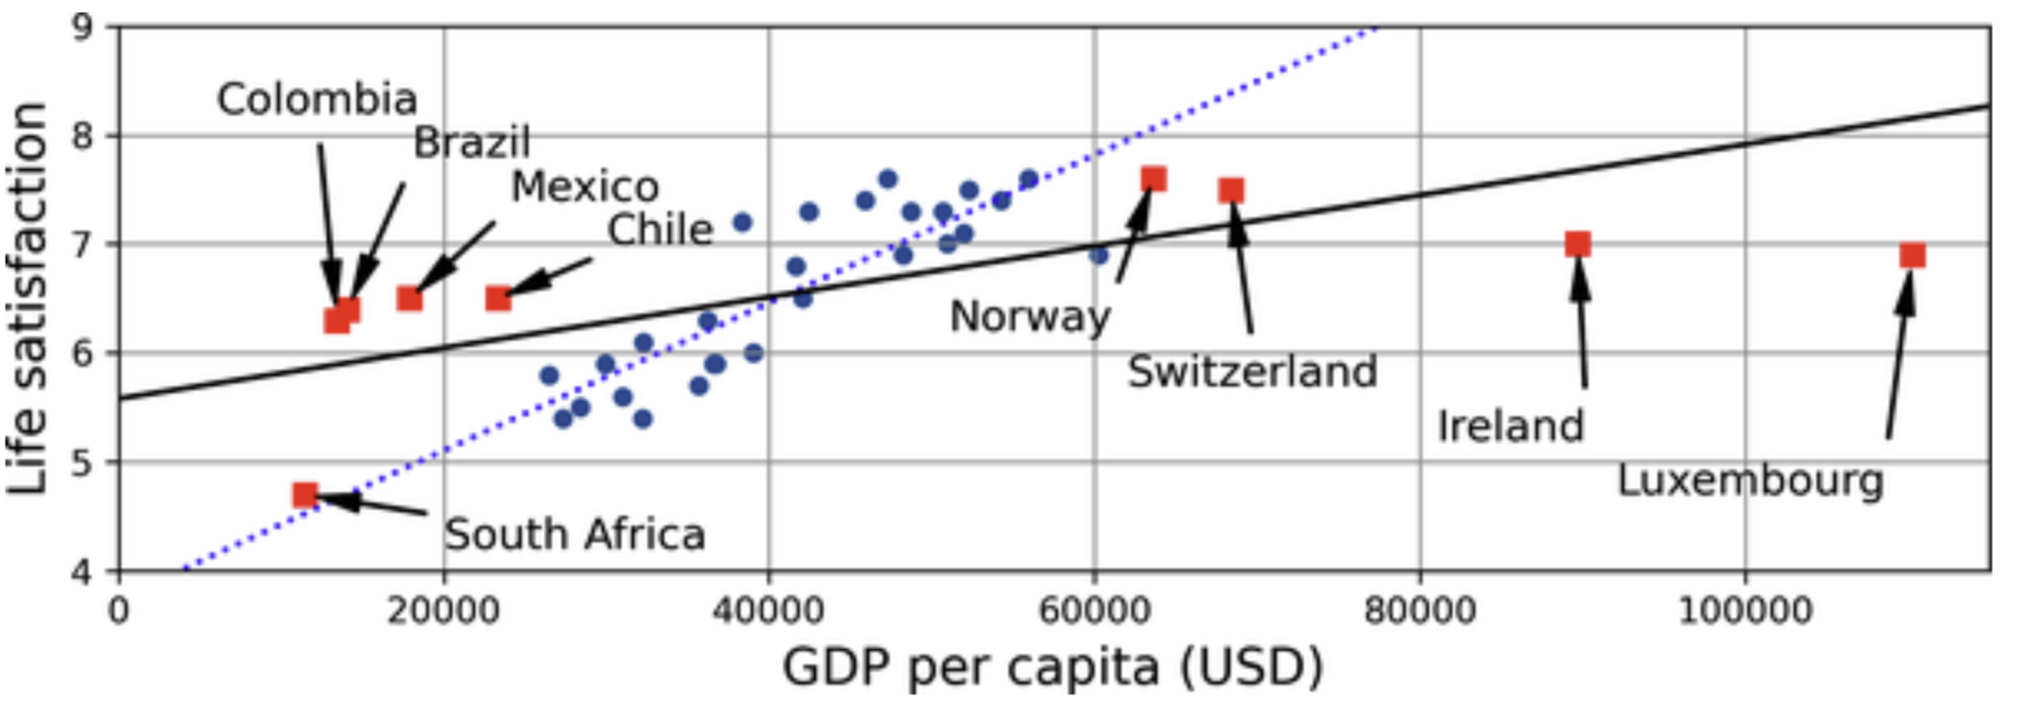

In [51]:
from IPython.display import Image
Image("Figs/Unrep.png", width=600)

- If the sample is too small, it may be non-representative by chance due to sampling noise.

- Even for a large sample size, if the sampling method is flawed, there may be sampling bias.